# Fetch and preprocess data

Fetch data from the database

In [1]:
from database_facade import db_facade

movies = db_facade.select_movies()
print(f'movies count: {len(movies)}')

movies count: 3025


Preprocess movie reviews helpers

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string
import re
import emoji

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Xotra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Xotra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Xotra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def convert_emoticons(text: str):
    emoticon_mapping = {
        ":)": "smile",
        ":-)": "smile",
        ":(": "sad",
        ":-(": "sad",
        ":D": "laugh",
        ":-D": "laugh"
    }
    
    words = text.split()
    converted_words = [emoticon_mapping.get(word, word) for word in words]
    converted_text = ' '.join(converted_words)
    
    return converted_text

def preprocess_text(text, return_tokens=False):

    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Remove urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)

    # Convert emoticons to text
    # text = convert_emoticons(text)

    # Replace emojis with names
    # text = emoji.demojize(text)

    # For now remove emojis completely - if the model works well might convert them to text as above
    text = emoji.replace_emoji(text, replace='')

    # Tokenization
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    # Text normalization
    tokens = [token.lower() for token in tokens]
    
    # Removing punctuation and elipsis
    tokens = [token for token in tokens if token not in string.punctuation and token != '...']
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return tokens if return_tokens else preprocessed_text

Split the data into training and test sets

In [5]:
train_test_split_ratio = 0.7

split_index = int(len(movies) * train_test_split_ratio)
train_movies = movies[:split_index]
test_movies = movies[split_index:]

print(f'Train movies count: {len(train_movies)}')
print(f'Test movies count: {len(test_movies)}')

Train movies count: 2117
Test movies count: 908


# Dataset and DataLoaders

TMDBDataset class used to load movie data:
- movies should be split to training and test sets before passing them to the class (either pass training or test)
- each poster gets normalised,
- each image has it's height adjusted, so all posters have the same sizes before inputting them to the VAE.
- each movie sample gets all it's reviews preprocessed and a list of preprocessed content is returned

In [15]:
from torch.utils.data import Dataset, DataLoader
from typing import List
from models.movie import Movie
import os
import cv2

class TMDBDataset(Dataset):
    def __init__(self, movies: List[Movie], directory, desired_image_shape, is_train):
        self.movies = movies
        self.directory = directory
        self.desired_image_shape = desired_image_shape
        self.is_train = is_train

    def __len__(self):
        # Calculate the number of batches per epoch
        return len(self.movies)

    def __getitem__(self, index: int):
        movie = self.movies[index]

        # ---- POSTERS ----
        file_path = movie.poster_path

        # Remove the '/' from the file path - the os lib uses '\' instead
        file_path = file_path[1:]

        # Load and preprocess the image
        image_path = os.path.join(self.directory, file_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Change image channels to RGB as cv2 reads BGR by default
        image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        resized_image = cv2.resize(image, (self.desired_image_shape[1], self.desired_image_shape[0])) # Resize the image to the desired width and height
        resized_image = resized_image.swapaxes(1, 2).swapaxes(0, 1)

        if self.is_train:
            return resized_image
        else:
            return resized_image, [preprocess_text(review.content) for review in movie.reviews]
        # return resized_image if self.is_train else resized_image, [preprocess_text(review.content) for review in movie.reviews]


# Posters

Draw a histogram of height distribution and find the minium and maximum pixel values

In [7]:
import matplotlib.pyplot as plt
from config import images_directory
import numpy as np

def draw_height_histogram():
    image_heights = []
    min_pixel_value = np.inf
    max_pixel_value = -np.inf

    for filename in os.listdir(images_directory):
        image_path = os.path.join(images_directory, filename)
        image = cv2.imread(image_path)

        height = image.shape[0]

        image_heights.append(height)

        current_min = np.min(image)
        current_max = np.max(image)
        
        if current_min < min_pixel_value:
            min_pixel_value = current_min
        if current_max > max_pixel_value:
            max_pixel_value = current_max

    num_unique_heights = len(set(image_heights))

    plt.hist(image_heights, bins=num_unique_heights)
    plt.xlabel('Image Height')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log') 
    plt.title('Distribution of Image Heights')
    plt.show()

    print(f'min pixel values:{min_pixel_value}')
    print(f'max pixel values:{max_pixel_value}')

In [2]:
# draw_height_histogram()

Instantiate the variational autoencoder and the train TMDBDataset class used for the DataLoader

In [16]:
from variational_autoencoder_torch import VariationalAutoencoder

desired_image_shape = (256, 224)
batch_size = 16
train_TMDB_dataset = TMDBDataset(train_movies, images_directory, desired_image_shape, is_train=True)
train_TMDB_data_loader = DataLoader(train_TMDB_dataset, batch_size, shuffle=True)

vae = VariationalAutoencoder(input_height=desired_image_shape[0], input_width=desired_image_shape[1], latent_dim=32, device="cuda")

Train the VAE model using the ImageDataLoader class

In [18]:
epochs = 10
epoch_avg_train_losses = vae.train(data_loader=train_TMDB_data_loader, epochs=epochs)

Epoch 10/10: 100%|██████████| 133/133 [01:34<00:00,  1.40batch/s]


Save the trained model

In [19]:
import torch

In [20]:
torch.save(vae.state_dict(), 'trained_models/vae_posters.pth')

Plot the average training loss per epoch

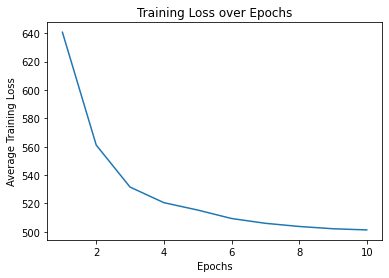

In [21]:
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, epoch_avg_train_losses)
plt.xlabel('Epochs')
plt.ylabel('Average Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

Show reconstruction examples

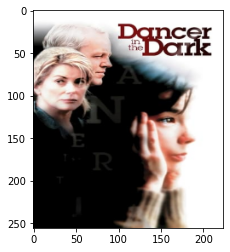

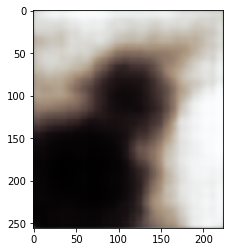

In [29]:
image = train_TMDB_dataset[5]
plt.imshow(image.swapaxes(0, 1).swapaxes(1, 2))

plt.show()

with torch.no_grad():
    reconstructed_image = vae(torch.Tensor(np.expand_dims(image, axis=0)).to("cuda"))
    plt.imshow(reconstructed_image[0][0].cpu().swapaxes(0, 1).swapaxes(1, 2))

# Reviews

 - The movie reviews are reduced using the pretrained bert model
 - for each movie from the dataset there can be more than 1 review
 - each review of a movie is reduced to a vector of 5 numbers representing scores from 1 to 5 (probability)
 - after calculating scores for all movie reviews an average vector is calculated, so each movie has one vector for its reviews
 - the review embeddings longer than 512 are truncated to fit the maximum input size for the network

In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from config import hf_reviews_model
from scipy.special import softmax

reviews_tokenizer = AutoTokenizer.from_pretrained(hf_reviews_model)
reviews_model = AutoModelForSequenceClassification.from_pretrained(hf_reviews_model)

In [44]:
test_TMDB_dataset = TMDBDataset(test_movies, images_directory, desired_image_shape, is_train=False)

In [45]:
def calculate_average(list_of_lists):
    array = np.array(list_of_lists)
    averages = np.mean(array, axis=0)
    avg_list = averages.tolist()
    return [round(score, 5) for score in avg_list]

In [46]:
average_movie_review_scores = []

for _, reviews in test_TMDB_dataset:
    movie_review_scores = []
    
    for review in reviews:
        review_embedding = reviews_tokenizer(review, return_tensors='pt', truncation=True, max_length=512)
        output = reviews_model(**review_embedding)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

        movie_review_scores.append(scores)

    average_movie_review_scores.append(calculate_average(movie_review_scores))

print(len(average_movie_review_scores))

c:\Users\Xotra\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


908


# Structural data

In [47]:
import pandas as pd

Create train pandas dataframe - for now only titles and overviews will be used to train separate Doc2Vec models

In [48]:
train_df = pd.DataFrame([
    {
        "title": movie.title,
        "overview": movie.overview,
    }
    for movie in train_movies
])

train_df

,title,overview
0,Shadows in Paradise,"Nikander, a rubbish collector and would-be ent..."
1,Star Wars,Princess Leia is captured and held hostage by ...
2,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp..."
3,American Beauty,"Lester Burnham, a depressed suburban father in..."
4,Citizen Kane,"Newspaper magnate, Charles Foster Kane is take..."
...,...,...
2112,The Wedding Singer,"Robbie, a local rock star turned wedding singe..."
2113,Wonder Boys,Grady is a 50-ish English professor who hasn't...
2114,Awakenings,"Dr. Malcolm Sayer, a shy research physician, u..."
2115,Smokey and the Bandit,A race car driver tries to transport an illega...


In [49]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

Train the Doc2Vec model for title embeddings and save the trained model

In [ ]:
train_titles_tagged_data = [TaggedDocument(words=preprocess_text(title, return_tokens=True), tags=[str(i)]) for i, title in enumerate(train_df['title'])]

titles_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=100)
titles_model.build_vocab(train_titles_tagged_data)
titles_model.train(train_titles_tagged_data, total_examples=titles_model.corpus_count, epochs=titles_model.epochs)

titles_model.save('trained_models/titles_doc2vec_model.bin')

Train the Doc2Vec model for overview embeddings and save the model

In [17]:
train_overviews_tagged_data = [TaggedDocument(words=preprocess_text(overview, return_tokens=True), tags=[str(i)]) for i, overview in enumerate(train_df['overview'])]

overviews_model = Doc2Vec(vector_size=200, window=5, min_count=1, workers=4, epochs=100)
overviews_model.build_vocab(train_overviews_tagged_data)
overviews_model.train(train_overviews_tagged_data, total_examples=overviews_model.corpus_count, epochs=overviews_model.epochs)

overviews_model.save('trained_models/overviews_doc2vec_model.bin')

c:\Users\Xotra\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Create the pandas dataframe using the test data and remove columns that are redundant, separate genres as labels

In [50]:
test_df = pd.DataFrame([
    vars(movie) for movie in test_movies
])

columns_to_drop = [
    '_sa_instance_state', # sql alchemy state object not needed for clustering
    'id', # id is only needed for the ORM
    'poster_path', # VAE will handle posters - later the reduced poster vectors will be added to the df
    'original_title', # not needed - title feature will do
    'backdrop_path', # backdrops are not processed
    'original_language', # the original language is always a part of spoken languages array property
    'reviews', # reviews are handled separately - scores vectors will be added later to the df
    'tagline', # about 60% of movies don't have taglines specified, so simply drop it
    'spoken_languages', # for now let's drop it - if there's time left OHE could be used - about 100 langues in db
    'production_countries', # same as above OHE can be used
    'production_companies' # same as above but don't know yet how to reduce
]

labels = test_df['genres']
test_df = test_df.drop(columns=['genres'])

test_df = test_df.drop(columns=columns_to_drop)


Convert the movie titles to embeddings using the trained Doc2Vec model

In [51]:
titles_model = Doc2Vec.load('trained_models/titles_doc2vec_model.bin')
title_embeddings = [titles_model.infer_vector(preprocess_text(title, return_tokens=True)) for title in test_df['title']]

title_embedding_column_dict = {f"title_embedding_{i}": [vector[i] for vector in title_embeddings] for i in range(100)}
title_embeddings_df = pd.DataFrame(title_embedding_column_dict)

test_df = pd.concat([test_df, title_embeddings_df], axis=1).drop(columns=['title'])

c:\Users\Xotra\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Convert the movie overviews to embeddings using the trained Doc2Vec model

In [52]:
overviews_model = Doc2Vec.load('trained_models/overviews_doc2vec_model.bin')
overview_embeddings = [overviews_model.infer_vector(preprocess_text(overview, return_tokens=True)) for overview in test_df['overview']]

overview_embedding_column_dict = {f"overview_embedding_{i}": [vector[i] for vector in overview_embeddings] for i in range(200)}
overview_embeddings_df = pd.DataFrame(overview_embedding_column_dict)

test_df = pd.concat([test_df, overview_embeddings_df], axis=1).drop(columns=['overview'])

c:\Users\Xotra\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Split the release_date column into 3 separate columns - year, month and day

In [53]:
test_df[['release_year', 'release_month', 'release_day']] = test_df['release_date'].str.split('-', expand=True)

test_df['release_year'] = test_df['release_year'].astype(int)
test_df['release_month'] = test_df['release_month'].astype(int)
test_df['release_day'] = test_df['release_day'].astype(int)

test_df = test_df.drop(columns=['release_date'])

Convert booleans to integer values

In [54]:
test_df['adult'] = test_df['adult'].astype(int)
test_df['video'] = test_df['adult'].astype(int)

Perform one hot encoding for the enum status column

In [55]:
status_encoded = pd.get_dummies(test_df['status'].apply(lambda x: x.name.lower()), prefix='status')

test_df = pd.concat([test_df, status_encoded], axis=1).drop(columns=['status'])

Reduce cast array to cast size, an average cast popularity and gender percentage vector

In [56]:
from models.person import Person

def reduce_people(people: List[Person]):
    people_count = len(people)
    avg_popularity = sum(person.popularity for person in people) / people_count

    gender_count = [0, 0, 0, 0]

    for person in people:
        gender_count[person.gender] +=1
    
    gender_percentage_vector = [count / people_count * 100 for count in gender_count]

    return people_count, avg_popularity, gender_percentage_vector

In [57]:
test_df[['cast_size', 'avg_cast_popularity', 'cast_gender_percentages']] = test_df['cast'].apply(reduce_people).apply(pd.Series)

test_df[['cast_non_specified_percentage', 'cast_male_percentage', 'cast_female_percentage', 'cast_non_binary_percentage']] = test_df['cast_gender_percentages'].apply(pd.Series)

test_df = test_df.drop(columns=['cast', 'cast_gender_percentages'])

Reduce directors array to number of directors, an average directors popularity and gender percentage vector

In [58]:
test_df[['number_of_directors', 'avg_directors_popularity', 'directors_gender_percentages']] = test_df['directors'].apply(reduce_people).apply(pd.Series)

test_df[['directors_non_specified_percentage', 'directors_male_percentage', 'directors_female_percentage', 'directors_non_binary_percentage']] = test_df['directors_gender_percentages'].apply(pd.Series)

test_df = test_df.drop(columns=['directors', 'directors_gender_percentages'])

Add the calculated average review scores to the df

In [59]:
avg_movie_scores_df = pd.DataFrame(average_movie_review_scores, columns=['1_star', '2_stars', '3_stars', '4_stars', '5_stars'])

test_df = pd.concat([test_df, avg_movie_scores_df], axis=1)

Add the poster embeddings returned by the trained VAE model

In [ ]:
vae: VariationalAutoencoder = torch.load('trained_models/vae_posters.pth')
vae.eval()

In [66]:
poster_embeddings = []

for poster, _ in test_TMDB_dataset:
    with torch.no_grad():
        poster_embedding_tensor = vae.get_feature_vector(torch.Tensor(np.expand_dims(poster, axis=0)).to("cuda"))
        poster_embedding = poster_embedding_tensor[0].cpu().detach().numpy()

        poster_embeddings.append(poster_embedding)

print(len(poster_embeddings))

c:\Users\Xotra\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


908


In [69]:
poster_embedding_column_dict = {f"poster_embedding_{i}": [vector[i] for vector in poster_embeddings] for i in range(32)}
poster_embeddings_df = pd.DataFrame(poster_embedding_column_dict)

In [70]:
test_df = pd.concat([test_df, poster_embeddings_df], axis=1)

In [75]:
test_df

,adult,budget,video,popularity,revenue,vote_average,vote_count,runtime,title_embedding_0,title_embedding_1,...,poster_embedding_22,poster_embedding_23,poster_embedding_24,poster_embedding_25,poster_embedding_26,poster_embedding_27,poster_embedding_28,poster_embedding_29,poster_embedding_30,poster_embedding_31
0,0,0,0,10.738,0,7.900,1039,109,-0.171402,0.009322,...,-0.067930,0.262520,0.493348,-0.138819,1.428930,1.064858,1.227680,-0.926077,1.043314,0.035419
1,0,0,0,19.744,7532911,6.600,387,111,-0.174306,0.011820,...,-0.736991,-1.564016,0.823415,-1.754270,0.819774,2.141160,1.455840,-1.250786,0.032158,-2.463018
2,0,4000000,0,24.643,9304609,6.796,1366,107,0.001134,0.002946,...,-0.774277,0.493245,0.189377,1.937130,1.362837,0.738285,1.656618,0.174523,0.403552,1.064717
3,0,60000000,0,13.557,33956608,5.968,450,110,-0.001519,-0.003913,...,0.086687,-2.123912,1.163583,-0.947764,1.320607,2.742190,2.500088,-0.423726,0.169799,-1.618071
4,0,0,0,9.879,0,7.500,451,100,-0.180100,0.017724,...,-0.501053,0.096179,0.774265,-2.156729,0.253997,-0.165588,0.687871,0.682065,-0.645397,-0.945909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,0,12000000,0,10.022,61141030,5.226,537,93,-0.004717,0.004419,...,-0.578095,0.199857,0.805738,0.371388,0.883558,0.776901,0.465854,-0.469094,-0.996284,-0.417060
904,0,0,0,5.981,0,6.694,98,85,-0.347427,0.036517,...,1.277813,-0.891097,1.396731,-1.253753,0.268259,1.370496,0.420877,0.066812,-0.791375,-1.257095
905,0,22000000,0,15.458,17280326,5.899,681,108,-0.188978,0.017752,...,-0.634729,-0.529397,-0.056574,0.194491,0.909209,1.852511,0.407170,-0.547665,-0.880373,-0.718792
906,0,0,0,10.438,0,7.446,288,99,-0.212584,0.005146,...,0.274055,-0.949669,0.833207,-0.719386,0.709649,1.677125,1.397465,-0.317948,-0.924431,-1.210384


In [74]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Columns: 361 entries, adult to poster_embedding_31
dtypes: float32(332), float64(17), int32(5), int64(6), uint8(1)
memory usage: 1.3 MB


# PCA

TODO - this PCA might be a bit stupid to perform - maybe each data type should have separate PCA, I assume that e.g. image embeddings get removed completely

In [77]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Standarize the features

In [79]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(test_df)

Create the PCA instance and fit the data

In [80]:
pca = PCA()
pca.fit(X_scaled)

PCA()

Create a bar chart to visualize the variance explained by each principal component

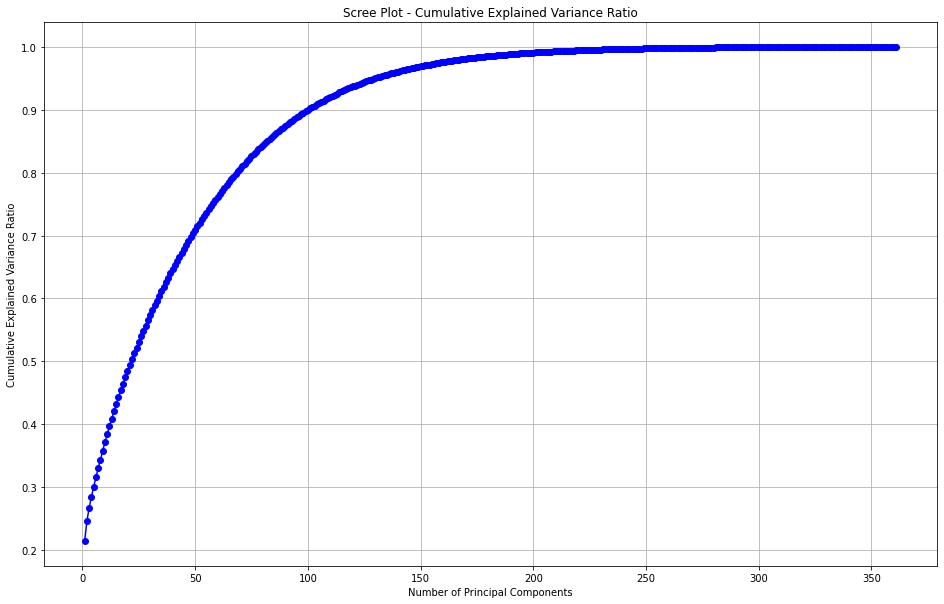

In [90]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)

# Create the scree plot
plt.figure(figsize=(16, 10))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot - Cumulative Explained Variance Ratio')
plt.grid()
plt.show()

Find the number of principal components that reach or exceed the threshold

In [91]:
desired_variance_threshold = 0.95

num_components_threshold = np.argmax(cumulative_variance >= desired_variance_threshold) + 1

print(f"Number of dimensions to keep for {desired_variance_threshold:.2f} threshold: {num_components_threshold}")

Number of dimensions to keep for 0.95 threshold: 130


Perform dimensionality reduction

In [95]:
pca.n_components = num_components_threshold
X_reduced = pca.fit_transform(X_scaled)

In [97]:
X_reduced_df = pd.DataFrame(X_reduced)

X_reduced_df

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,4.224472,-1.612246,-0.179908,0.481778,1.391197,-0.668152,0.831074,0.055466,1.020493,3.781683,...,-0.764837,0.420480,-0.302998,0.792880,-0.522925,0.143895,0.327658,-0.247561,-0.167391,-0.254840
1,4.550649,1.887874,-1.518575,-0.455502,1.470781,-2.072819,1.702615,-2.218386,-1.625440,2.173176,...,0.228931,-0.628118,-0.370623,-0.432580,-0.864745,-0.259481,-0.757935,0.666784,0.085784,-0.842143
2,-9.561955,-5.914814,0.535853,4.451266,1.359754,1.537322,1.732234,-0.541619,0.488564,-2.228822,...,-0.019541,0.956864,-0.174020,0.523669,-0.511340,-0.809044,0.616126,0.067312,0.481043,0.096741
3,-9.575586,4.558576,-1.149819,1.540013,-0.049724,1.253393,0.538404,0.189765,-4.161378,2.083004,...,0.757827,0.044482,0.139218,0.315339,0.007751,-0.406340,-0.209135,0.794594,0.107877,0.111476
4,4.819045,3.085731,-1.570929,-2.641237,-0.035344,0.164566,-1.509931,-0.807515,0.021186,1.961057,...,-0.613405,-0.024658,0.147570,-0.348664,-0.833020,1.371409,0.566757,0.288248,0.268666,0.186854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,-9.062977,-3.617466,0.629115,1.183394,1.880250,4.431248,-1.843753,2.220333,9.836667,-1.516821,...,-0.265345,1.382604,-0.407041,0.714464,-0.405802,0.760255,-0.012022,-0.508491,-0.561394,0.293026
904,18.177379,1.533719,-0.587730,-0.739249,-1.218760,-2.086146,3.440668,0.482106,-0.546511,0.610010,...,0.319251,-0.601796,0.252732,-0.231370,-0.073623,0.263535,-0.654483,-0.100458,0.402824,-0.538529
905,5.528659,-0.076175,-1.978489,2.632272,-5.360929,5.583314,0.819068,0.927394,2.275709,-1.570883,...,0.091681,0.618166,-0.619809,0.497738,0.800642,-0.112589,0.441627,0.190241,0.178950,0.210178
906,6.677285,-0.501096,-2.952715,1.327981,0.805336,1.525214,1.966225,-1.072366,0.382543,1.846156,...,-0.342499,0.363679,0.291927,-0.186431,-0.081649,-0.107565,0.279560,-0.136264,-0.405691,0.741676


# Clustering and Validation